<a href="https://colab.research.google.com/github/JohannesKarwou/notebooks/blob/main/combinedDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import scipy
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib.legend_handler import HandlerTuple

plt.set_loglevel("WARNING")

In [2]:
# set up color palette
palett = sns.color_palette(n_colors=8)
palett_as_hex = palett.as_hex()

c1, c2, c3, c4, c5, c7 = (
    palett_as_hex[0],
    palett_as_hex[1],
    palett_as_hex[2],
    palett_as_hex[3],
    palett_as_hex[4],
    palett_as_hex[6],
)
c8 = matplotlib.colors.to_rgba("k", alpha=0.1)
c8_2 = matplotlib.colors.to_rgba("k", alpha=0.01)
# c5 = lila
# c7= rosa

In [3]:
# Reading the combined Datset containing 156 molecules (-> data)
data = pd.read_csv("sample_data/combinedDataset.csv")
all_data = pd.read_csv("sample_data/freesolvEXSdata.csv", skiprows=1)
# Reading the EXS dataset with 589 molecules (-> all_data)
data["MM-ML"] = np.abs(data["MM-ASFE [kcal/mol]"] - data["ML-ASFE [kcal/mol]"])
all_data["EXS correction"] = np.abs(
    all_data["ML-ASFE [kcal/mol]"] - all_data["MM-ASFE [kcal/mol]"]
)

In [ ]:
def bootstrap_metric(fct, x_values, y_values, p_value=False):
    bootstrapped_metric = []
    # bootstrap metric to generate test distribution
    for _ in range(1000):
        indices = np.random.choice(
            range(0, len(x_values)), size=len(x_values), replace=True
        )
        x_selection = np.take(x_values, indices)
        y_selection = np.take(y_values, indices)
        if p_value:
            r = fct(x_selection, y_selection)[0]
        else:
            r = fct(x_selection, y_selection)
        bootstrapped_metric.append(r)

    # define 95% CI
    alpha = 5.0
    lower_p = alpha / 2.0
    # get value at or near percentile (take a look at the definition of percentile if
    # you have less than 100 values to make sure you understand what is happening)
    lower = np.percentile(bootstrapped_metric, lower_p)
    upper_p = (100 - alpha) + (alpha / 2.0)
    upper = np.percentile(bootstrapped_metric, upper_p)
    # calculate true mean
    if p_value:
        mean = fct(x_values, y_values)[0]
    else:
        mean = fct(x_values, y_values)
    return mean, lower, upper


def calculate_statistics(x_values, y_values, output=False):
    # bootstrap RMSE
    def calc_rmse(x_values, y_values):
        return np.sqrt(mean_squared_error(x_values, y_values))

    rmse = bootstrap_metric(calc_rmse, x_values, y_values)

    # bootstrap MAE
    mae = bootstrap_metric(
        mean_absolute_error, x_values, y_values
    )

    # bootstrap Pearson
    pearson = bootstrap_metric(
        scipy.stats.pearsonr, x_values, y_values, p_value=True
    )

    # bootstrap Spearman
    spearman = bootstrap_metric(
        scipy.stats.spearmanr, x_values, y_values, p_value=True
    )

    # bootstrap Kendalltau
    kendall = bootstrap_metric(
        scipy.stats.kendalltau, x_values, y_values, p_value=True
    )
    if output:
        print(f"{rmse=}")
        print(f"{kendall=}")
        print(f"{mae=}")
        print(f"{pearson=}")
        print(f"{spearman=}")

    return (
        tuple([float("{0:.2f}".format(n)) for n in rmse]),
        tuple([float("{0:.2f}".format(n)) for n in mae]),
        tuple([float("{0:.2f}".format(n)) for n in pearson]),
        tuple([float("{0:.2f}".format(n)) for n in spearman]),
        tuple([float("{0:.2f}".format(n)) for n in kendall]),
    )

In [ ]:
rmse_mm = np.sqrt(
    np.mean((all_data["Exp [kcal/mol]"] - all_data["MM-ASFE [kcal/mol]"]) ** 2)
)

assert round(rmse_mm,2) == calculate_statistics(all_data["Exp [kcal/mol]"],all_data["MM-ASFE [kcal/mol]"])[0][0]

Full dataset -- only for the 589 compounds calculated by Exscientia

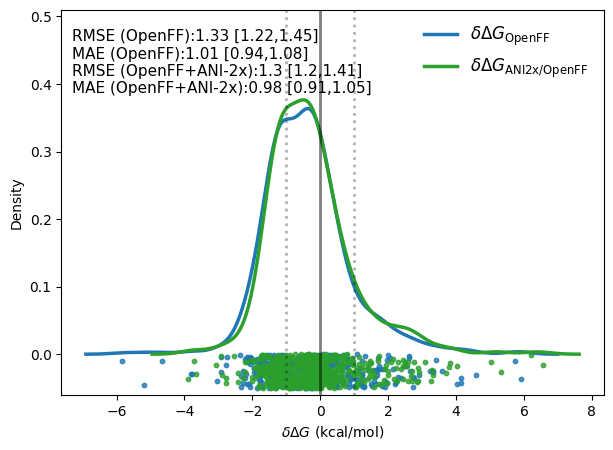

In [ ]:
plt.figure(figsize=(7, 5))

sns.kdeplot(
    data=all_data["Exp [kcal/mol]"] - all_data["MM-ASFE [kcal/mol]"],
    lw=2.5,
    c=c1,
    label=r"$\delta\Delta G_{\mathrm{OpenFF}}$",
)
sns.kdeplot(
    data=all_data["Exp [kcal/mol]"] - all_data["ML-ASFE [kcal/mol]"],
    lw=2.5,
    c=c3,
    label=r"$\delta\Delta G_{\mathrm{ANI2x/OpenFF}}$",
)
plt.scatter(
    all_data["Exp [kcal/mol]"] - all_data["MM-ASFE [kcal/mol]"],
    np.random.uniform(low=-0.05, high=0.0, size=len(all_data["ML-ASFE [kcal/mol]"])),
    s=10,
    color=c1,
    alpha=0.8,
)
plt.scatter(
    all_data["Exp [kcal/mol]"] - all_data["ML-ASFE [kcal/mol]"],
    np.random.uniform(low=-0.05, high=0, size=len(all_data["ML-ASFE [kcal/mol]"])),
    s=10,
    color=c3,
    alpha=0.8,
)

plt.axvline(x=-1, color="black", lw=2, alpha=0.3, ls=":")
plt.axvline(x=0.0, color="black", lw=2, alpha=0.5, ls="-")
plt.axvline(x=1, color="black", lw=2, alpha=0.3, ls=":")

rmse,mae,_,_,_ = calculate_statistics(all_data["Exp [kcal/mol]"],all_data["MM-ASFE [kcal/mol]"])
rmse_ml,mae_ml,_,_,_ = calculate_statistics(all_data["Exp [kcal/mol]"],all_data["ML-ASFE [kcal/mol]"])

# backup formulas: $(\delta \Delta G_{{OpenFF}})$ and $(\delta \Delta G_{{OpenFF + ANI2x}}$
axs = plt.gca()
axs.text(
    0.02,
    0.95,
    f"RMSE (OpenFF):{rmse[0]} [{rmse[1]},{rmse[2]}]\nMAE (OpenFF):{mae[0]} [{mae[1]},{mae[2]}]\nRMSE (OpenFF+ANI-2x):{rmse_ml[0]} [{rmse_ml[1]},{rmse_ml[2]}]\nMAE (OpenFF+ANI-2x):{mae_ml[0]} [{mae_ml[1]},{mae_ml[2]}]",
    transform=axs.transAxes,
    fontsize=11,
    verticalalignment="top",
)

plt.ylim([-0.06, 0.51])
plt.legend(fontsize=12, frameon=False)
plt.xlabel(r"$\delta \Delta G$ (kcal/mol)")

plt.savefig("KDEallData.pdf", bbox_inches="tight")

Combined dataset, for the data calculated by EXS and UVIE

t-test for combined dataset of the **OpenFF** results

In [8]:
scipy.stats.ttest_rel((np.abs(data["Exp [kcal/mol]"]-data["MM-ASFE [kcal/mol]"])),(np.abs(data["Exp [kcal/mol]"]-data["ML-ASFE [kcal/mol]"])))

TtestResult(statistic=4.4305419687471925, pvalue=1.768470776394731e-05, df=155)

t-test for combinded dataset of the **CGenFF** results

In [6]:
scipy.stats.ttest_rel((np.abs(data["Exp [kcal/mol]"]-data["dG (TF) lrc"])),(np.abs(data["Exp [kcal/mol]"]-data["Jar result"])))

TtestResult(statistic=2.4215394413379387, pvalue=0.01660947744970128, df=155)

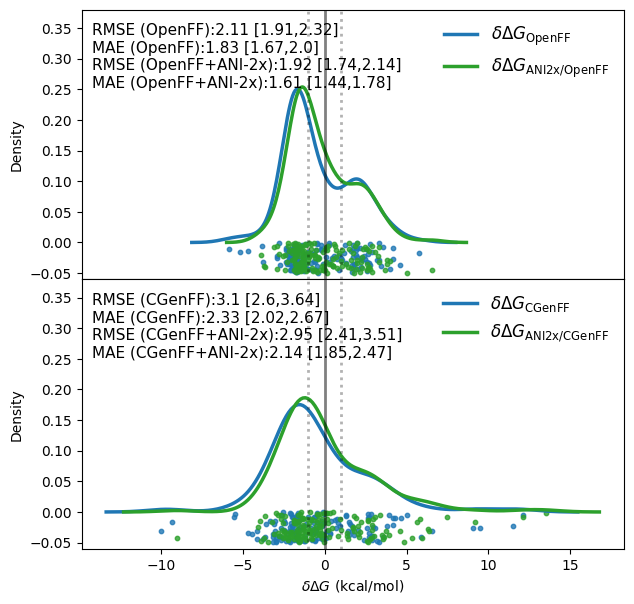

In [ ]:
fig, ax = plt.subplots(
    2,
    1,
    figsize=(7, 7),
    sharex=True,
    sharey=True,
)
fig.subplots_adjust(hspace=0, wspace=0.0)

########## First plot - OpenFF #################

sns.kdeplot(
    data=data["Exp [kcal/mol]"] - data["MM-ASFE [kcal/mol]"],
    lw=2.5,
    ax=ax[0],
    c=c1,
    label=r"$\delta\Delta G_{\mathrm{OpenFF}}$",
)
sns.kdeplot(
    data=data["Exp [kcal/mol]"] - data["ML-ASFE [kcal/mol]"],
    lw=2.5,
    c=c3,
    ax=ax[0],
    label=r"$\delta\Delta G_{\mathrm{ANI2x/OpenFF}}$",
)

ax[0].axvline(x=-1, color="black", lw=2, alpha=0.3, ls=":")
ax[0].axvline(x=0.0, color="black", lw=2, alpha=0.5, ls="-")
ax[0].axvline(x=1, color="black", lw=2, alpha=0.3, ls=":")

ax[0].scatter(
    data["Exp [kcal/mol]"] - data["MM-ASFE [kcal/mol]"],
    np.random.uniform(low=-0.05, high=0.0, size=len(data["ML-ASFE [kcal/mol]"])),
    s=10,
    color=c1,
    alpha=0.8,
)
ax[0].scatter(
    data["Exp [kcal/mol]"] - data["ML-ASFE [kcal/mol]"],
    np.random.uniform(low=-0.05, high=0, size=len(data["ML-ASFE [kcal/mol]"])),
    s=10,
    color=c3,
    alpha=0.8,
)

rmse,mae,_,_,_ = calculate_statistics(data["Exp [kcal/mol]"],data["MM-ASFE [kcal/mol]"])
rmse_ml,mae_ml,_,_,_ = calculate_statistics(data["Exp [kcal/mol]"],data["ML-ASFE [kcal/mol]"])

ax[0].text(
    0.02,
    0.95,
    f"RMSE (OpenFF):{rmse[0]} [{rmse[1]},{rmse[2]}]\nMAE (OpenFF):{mae[0]} [{mae[1]},{mae[2]}]\nRMSE (OpenFF+ANI-2x):{rmse_ml[0]} [{rmse_ml[1]},{rmse_ml[2]}]\nMAE (OpenFF+ANI-2x):{mae_ml[0]} [{mae_ml[1]},{mae_ml[2]}]",
    transform=ax[0].transAxes,
    fontsize=11,
    verticalalignment="top",
)

ax[0].legend(fontsize=12, frameon=False)

########### Second PLOT - CGENFF ############

sns.kdeplot(
    data=data["Exp [kcal/mol]"] - data["dG (TF) lrc"],
    lw=2.5,
    ax=ax[1],
    c=c1,
    label=r"$\delta\Delta G_{\mathrm{CGenFF}}$",
)
sns.kdeplot(
    data=data["Exp [kcal/mol]"] - data["Jar result"],
    lw=2.5,
    c=c3,
    ax=ax[1],
    label=r"$\delta\Delta G_{\mathrm{ANI2x/CGenFF}}$",
)

ax[1].axvline(x=-1, color="black", lw=2, alpha=0.3, ls=":")
ax[1].axvline(x=0.0, color="black", lw=2, alpha=0.5, ls="-")
ax[1].axvline(x=1, color="black", lw=2, alpha=0.3, ls=":")

ax[1].scatter(
    data["Exp [kcal/mol]"] - data["dG (TF) lrc"],
    np.random.uniform(low=-0.05, high=0.0, size=len(data["Jar result"])),
    s=10,
    color=c1,
    alpha=0.8,
)
ax[1].scatter(
    data["Exp [kcal/mol]"] - data["Jar result"],
    np.random.uniform(low=-0.05, high=0, size=len(data["Jar result"])),
    s=10,
    color=c3,
    alpha=0.8,
)

rmse,mae,_,_,_ = calculate_statistics(data["Exp [kcal/mol]"],data["dG (TF) lrc"])
rmse_ml,mae_ml,_,_,_ = calculate_statistics(data["Exp [kcal/mol]"],data["Jar result"])

ax[1].text(
    0.02,
    0.95,
    f"RMSE (CGenFF):{rmse[0]} [{rmse[1]},{rmse[2]}]\nMAE (CGenFF):{mae[0]} [{mae[1]},{mae[2]}]\nRMSE (CGenFF+ANI-2x):{rmse_ml[0]} [{rmse_ml[1]},{rmse_ml[2]}]\nMAE (CGenFF+ANI-2x):{mae_ml[0]} [{mae_ml[1]},{mae_ml[2]}]",
    transform=ax[1].transAxes,
    fontsize=11,
    verticalalignment="top",
)

plt.ylim([-0.06, 0.38])

ax[1].legend(fontsize=12, frameon=False)
ax[1].set_xlabel(r"$\delta \Delta G$ (kcal/mol)")
plt.savefig("KDEcombined.pdf", bbox_inches="tight")

In [ ]:
!pip install rdkit
!pip install cairosvg

from cairosvg import svg2png
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from collections import OrderedDict
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import GraphDescriptors
from rdkit.Chem import rdDistGeom, rdForceFieldHelpers
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import DrawingOptions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 4.0 MB/s eta 0:00:00


In [ ]:
data.loc[:, "numRotBonds"] = np.nan
data.loc[:, "aromatic"] = np.nan

numRotBonds = {}
for index, row in data.iterrows():
    try:
        smi = row[" SMILES"].strip()
        correction = row["MM-ML"]
        mol = Chem.MolFromSmiles(smi)
        # display(mol)
        rotBonds = rdMolDescriptors.CalcNumRotatableBonds(mol)
        data.loc[index, "numRotBonds"] = rotBonds
        # print(rotBonds)
        if any(atom.GetIsAromatic() for atom in mol.GetAtoms()):
            data.loc[index, "aromatic"] = True
        else:
            data.loc[index, "aromatic"] = False

        try:
            numRotBonds[rotBonds].append(correction)

        except KeyError:
            numRotBonds[rotBonds] = []
            numRotBonds[rotBonds].append(correction)
    except AttributeError:
        pass

In [ ]:
myKeys = list(numRotBonds.keys())
myKeys.sort()
sorted_dict = {i: numRotBonds[i] for i in myKeys}

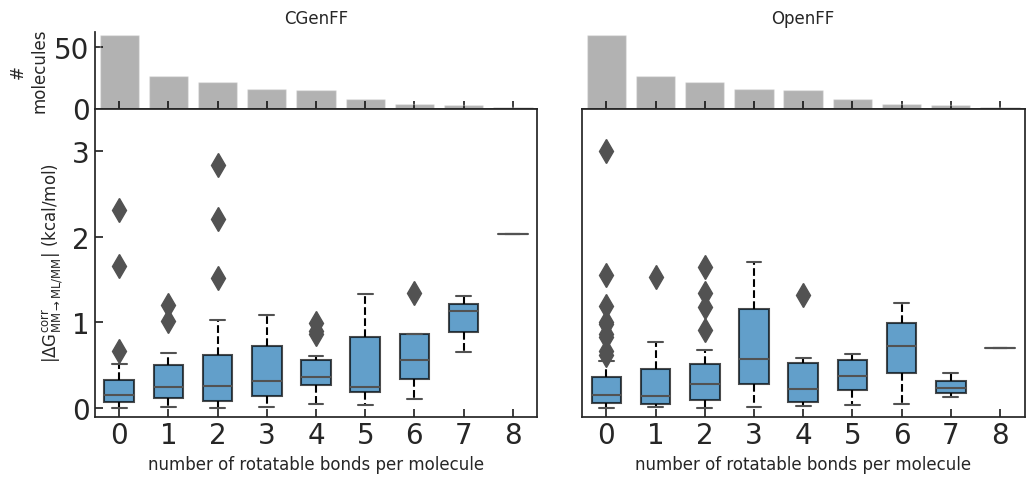

In [ ]:
sns.reset_orig
sns.set_theme(
    style="white",
    rc={
        "font.size": 18,
        "legend.fontsize": 10,
        "lines.markersize": 10,
        "xtick.bottom": True,
        "xtick.direction": "in",
        "xtick.labelsize": 20,
        "ytick.left": True,
        "ytick.direction": "in",
        "ytick.labelsize": 20,
    },
)

fig, ax = plt.subplots(2, 2, figsize=(12, 5), sharey=False, sharex=True, gridspec_kw={"height_ratios": [1, 4]})
fig.subplots_adjust(hspace=0, wspace=0.10)

ax = ax.ravel()

ax[0].bar(sorted_dict.keys(),[len(i) for i in sorted_dict.values()],color="black",alpha=0.3)

ax[0].set_xticks([])
ax[0].set_ylabel("# \nmolecules")
ax[0].spines['left'].set_visible(True)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

ax[1].bar(sorted_dict.keys(),[len(i) for i in sorted_dict.values()],color="black",alpha=0.3)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].spines['left'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

##### Aromatizitaet #############
# sns.boxplot(
#     # data=data,
#     x=[int(i) for i in data["numRotBonds"].to_list()],
#     y=np.abs(data["Crooks correction"]),
#     hue=data["aromatic"],
#     ax=ax1,
#     width=0.6,
#     # medianprops=medianprops,
#     showmeans=False,
#     # meanprops=meanprops,
#     # order=labeling.index,
#     color=c1,
#     saturation=1,
#     linewidth=1.5,
#     # palette={"GAFF": "C1", "CGenFF": "C0"},
#     fliersize=12,
#     autorange=True,
#     # orient="h",
#     showfliers=False,
#     whis=0.9,
#     # boxprops=dict(facecolor=c1, alpha=0.7, edgecolor="black", linewidth=1.5),
#     whiskerprops=dict(linestyle="--", linewidth=1.5, color="black"),
# )

sns.boxplot(
    # data=data,
    x=[int(i) for i in data["numRotBonds"].to_list()],
    y=np.abs(data["Jar correction"]),
    # hue="Force Field",
    ax=ax[2],
    width=0.6,
    # medianprops=medianprops,
    showmeans=False,
    # meanprops=meanprops,
    # order=labeling.index,
    color="C3",
    saturation=1,
    linewidth=1.5,
    # palette={"GAFF": "C1", "CGenFF": "C0"},
    fliersize=12,
    autorange=True,
    # orient="h",
    showfliers=True,
    whis=0.8,
    boxprops=dict(facecolor=c1, alpha=0.7, edgecolor="black", linewidth=1.5),
    whiskerprops=dict(linestyle="--", linewidth=1.5, color="black"),
)


sns.boxplot(
    # data=data,
    x=[int(i) for i in data["numRotBonds"].to_list()],
    y=np.abs(data["MM-ML"]),
    # hue="Force Field",
    ax=ax[3],
    width=0.6,
    # medianprops=medianprops,
    showmeans=False,
    # meanprops=meanprops,
    # order=labeling.index,
    color="C3",
    saturation=1,
    linewidth=1.5,
    # palette={"GAFF": "C1", "CGenFF": "C0"},
    fliersize=12,
    autorange=True,
    # orient="h",
    showfliers=True,
    whis=0.8,
    boxprops=dict(facecolor=c1, alpha=0.7, edgecolor="black", linewidth=1.5),
    whiskerprops=dict(linestyle="--", linewidth=1.5, color="black"),
)

ax[2].yaxis.set_major_locator(MaxNLocator(integer=True))
ax[2].set_ylabel(
    r"$|\Delta \mathrm{G}^{\mathrm{corr}}_{\mathrm{MM}\rightarrow\mathrm{ML/MM}}|$ (kcal/mol)"
)
ax[2].set_xlabel("number of rotatable bonds per molecule")
ax[3].set_xlabel("number of rotatable bonds per molecule")
ax[3].set_ylabel("")

ax[0].set_title("CGenFF")
ax[1].set_title("OpenFF")
ax[2].set_ylim([-0.1, 3.5])
ax[3].set_yticks([])
ax[3].set_ylim([-0.1, 3.5])

# fig.tight_layout()
plt.savefig("boxplot_numRotBonds.pdf", bbox_inches="tight")

In [ ]:
outlier_cgenff = [
    "mobley_7203421",
    "mobley_2958326",
    "mobley_1896013",
    "mobley_9257453",
    "mobley_9534740",
    "mobley_337666",
    "mobley_2126135",
    "mobley_3515580",
    "mobley_6917738",
    "mobley_3259411",
    "mobley_4603202",
    "mobley_4587267",
]
outlier_openff = [
    "mobley_1708457",
    "mobley_242480",
    "mobley_1896013",
    "mobley_4780078",
    "mobley_3323117",
    "mobley_4850657",
    "mobley_9534740",
    "mobley_2850833",
    "mobley_2126135",
    "mobley_6854178",
    "mobley_3259411",
    "mobley_5816127",
    "mobley_6917738",
    "mobley_4687447",
    "mobley_4587267",
]

In [ ]:
subset_cgenff = data[data["Mol_ID"].isin(outlier_cgenff)]
subset_cgenff = subset_cgenff.sort_values(by="Jar correction")

subset_openff = data[data["Mol_ID"].isin(outlier_openff)]
subset_openff = subset_openff.sort_values(by="MM-ML", ascending=False)

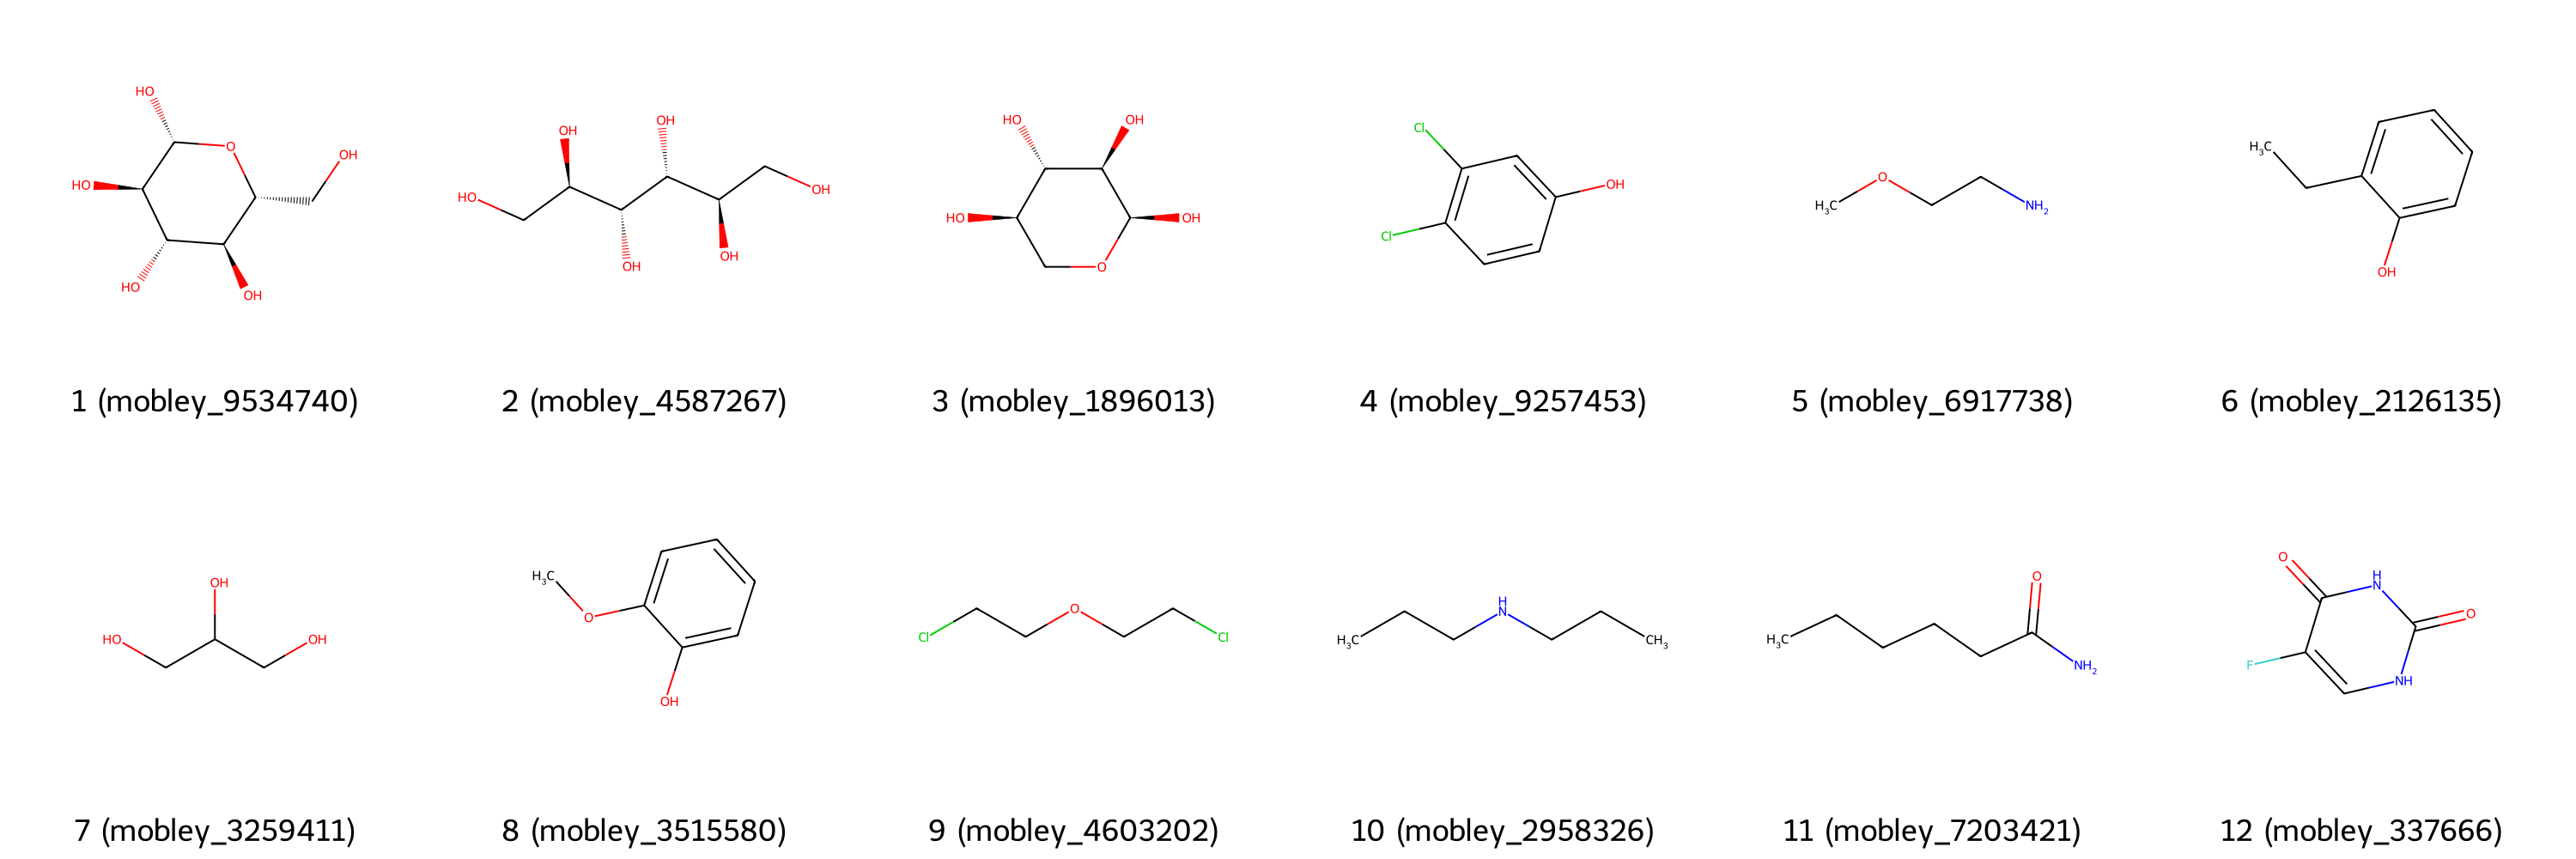

In [ ]:
name = []
smiles = []
highlight = []
i = 1

for index, row in subset_cgenff.iterrows():
    smiles.append(row[" SMILES"])
    name.append(f'{i} ({row["Mol_ID"]})')
    i += 1

    # if row["Mol_ID"] in outlier_openff:
    #     print(row["Mol_ID"])
    #     stop = mol.GetNumAtoms()
    #     highlight.append(np.ndarray.tolist(np.arange(0,stop)))
    # else:
    #     highlight.append([])

ms = [Chem.MolFromSmiles(x) for x in smiles]

# IPythonConsole.drawOptions.baseFontSize = 5
IPythonConsole.drawOptions.explicitMethyl = True
IPythonConsole.drawOptions.fixedFontSize = 15
IPythonConsole.drawOptions.legendFontSize = 35


img = Draw.MolsToGridImage(
    ms, subImgSize=(500, 500), molsPerRow=6, legends=name, returnPNG=True
)
img

# svg2png(bytestring=img.data, write_to=f"images/cgenff.png")

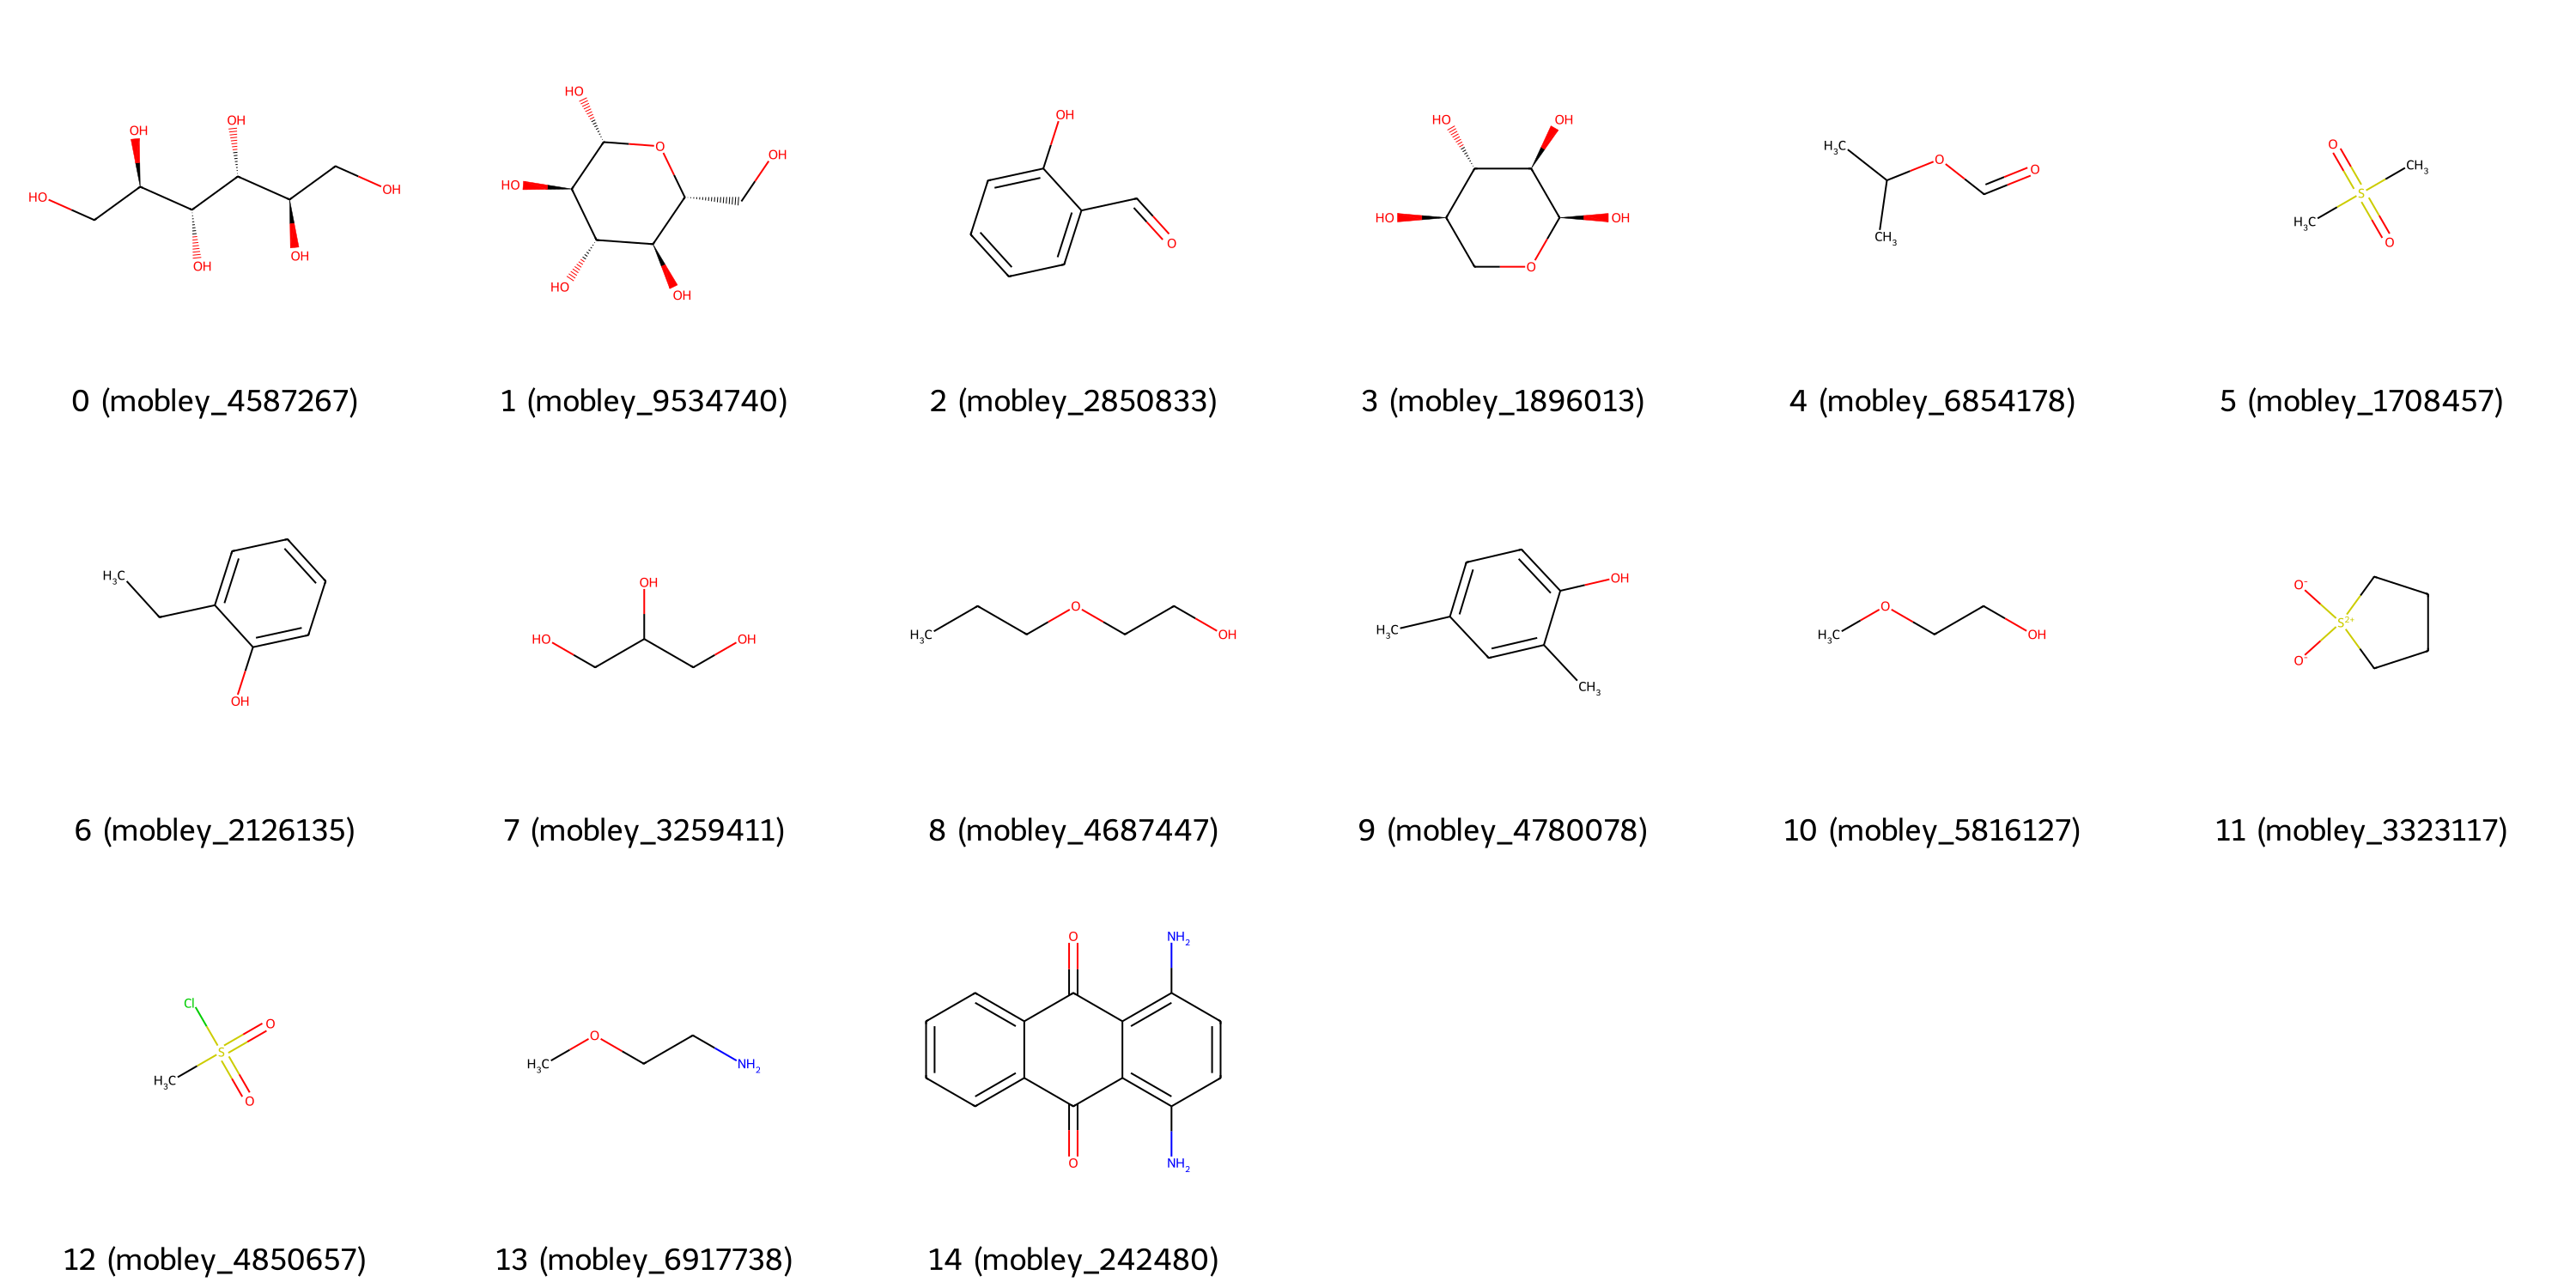

In [ ]:
name = []
smiles = []
i = 0
for index, row in subset_openff.iterrows():
    smiles.append(row[" SMILES"])
    name.append(f'{i} ({row["Mol_ID"]})')
    i += 1

ms = [Chem.MolFromSmiles(x) for x in smiles]

# IPythonConsole.drawOptions.baseFontSize = 5
IPythonConsole.drawOptions.explicitMethyl = True
IPythonConsole.drawOptions.fixedFontSize = 15
IPythonConsole.drawOptions.legendFontSize = 35


img = Draw.MolsToGridImage(
    ms, subImgSize=(500, 500), molsPerRow=6, legends=name, returnPNG=True
)
img

# svg2png(bytestring=img.data, write_to=f"images/initialRound.png")

In [ ]:
tf_data = pd.read_csv(
    "https://raw.githubusercontent.com/JohannesKarwou/notebooks/main/data/freeSolvCGenFF.csv"
)
gaff_data = pd.read_csv(
    "https://raw.githubusercontent.com/MobleyLab/FreeSolv/master/database.txt",
    sep=";",
    skiprows=2,
)
openff_data = all_data
openff_data.rename(columns={"Mol_ID": "# compound id (and file prefix)"}, inplace=True)
combined_data = pd.merge(
    tf_data, openff_data, on="# compound id (and file prefix)", how="left"
)
combined_data = combined_data.dropna(subset=["MM-ASFE [kcal/mol]"])

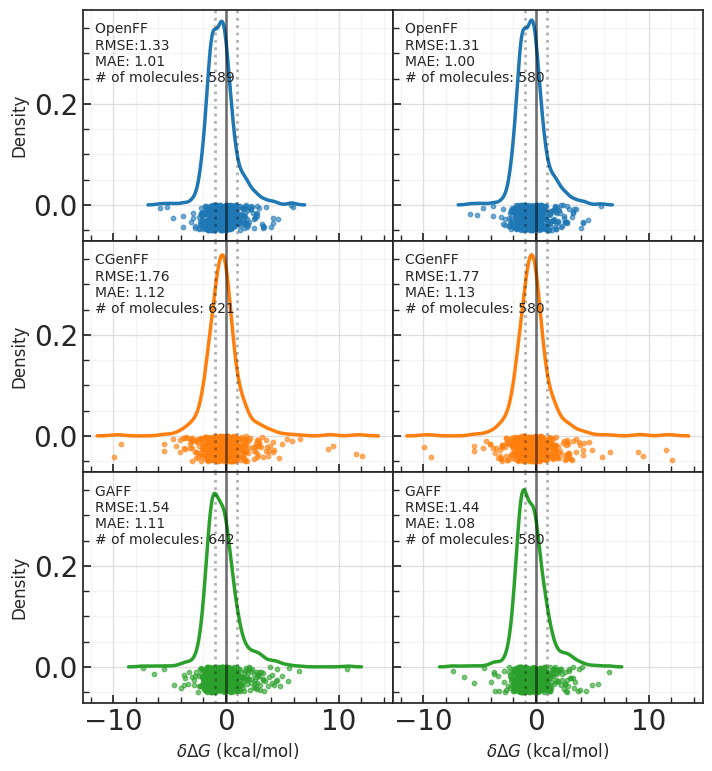

In [ ]:
fig, ax = plt.subplots(
    3,
    2,
    figsize=(8, 9),
    sharex=True,
    sharey=True,
)
fig.subplots_adjust(hspace=0, wspace=0.0)


def plot_subplot(df, x, y, ff, i, j, color):
    sns.kdeplot(data=df[x] - df[y], lw=2.5, ax=ax[i, j], c=color)
    # sns.histplot(data=df[x] - df[y], lw=2.5,kde=True, ax=ax[i, j],binwidth=0.2, color=color)
    ax[i, j].axvline(x=-1, color="black", lw=2, alpha=0.3, ls=":")
    ax[i, j].axvline(x=0.0, color="black", lw=2, alpha=0.5, ls="-")
    ax[i, j].axvline(x=1, color="black", lw=2, alpha=0.3, ls=":")

    ax[i, j].scatter(
        df[x] - df[y],
        np.random.uniform(low=-0.05, high=0.0, size=len(df[y])),
        s=10,
        color=color,
        alpha=0.6,
    )

    rmse = np.sqrt(np.mean((df[x] - df[y]) ** 2))
    mae = np.mean(np.abs(df[x] - df[y]))
    at = AnchoredText(
        f"{ff} \nRMSE:{rmse:.2f} \nMAE: {mae:.2f} \n# of molecules: {len(df[y])}",
        prop={"fontsize": 10},
        frameon=False,
        loc="upper left",
    )
    ax[i, j].add_artist(at)
    ax[i, j].grid(which="major", alpha=0.6)
    ax[i, j].grid(which="minor", alpha=0.2)
    ax[i, j].minorticks_on()  # Enable minor ticks


####### First Plot - OpenFF results #############

plot_subplot(all_data, "Exp [kcal/mol]", "MM-ASFE [kcal/mol]", "OpenFF", 0, 0, c1)

########### Second PLOT - CGENFF TF ############

plot_subplot(
    tf_data, " experimental value (kcal/mol)", "dG (TF) lrc", "CGenFF", 1, 0, c2
)

########### Third PLOT - GAFF results ############

plot_subplot(
    gaff_data,
    " experimental value (kcal/mol)",
    " Mobley group calculated value (GAFF) (kcal/mol)",
    "GAFF",
    2,
    0,
    c3,
)

####### First Plot - OpenFF results #############

plot_subplot(combined_data, "Exp [kcal/mol]", "MM-ASFE [kcal/mol]", "OpenFF", 0, 1, c1)

########### Second PLOT - CGENFF TF ############

plot_subplot(
    combined_data, " experimental value (kcal/mol)", "dG (TF) lrc", "CGenFF", 1, 1, c2
)

########### Third PLOT - GAFF results ############

plot_subplot(
    combined_data,
    " experimental value (kcal/mol)",
    " Mobley group calculated value (GAFF) (kcal/mol)",
    "GAFF",
    2,
    1,
    c3,
)

ax[2, 0].set_xlabel(r"$\delta \Delta G$ (kcal/mol)")
ax[2, 1].set_xlabel(r"$\delta \Delta G$ (kcal/mol)")
plt.savefig("KDEofASFE.pdf", bbox_inches="tight")

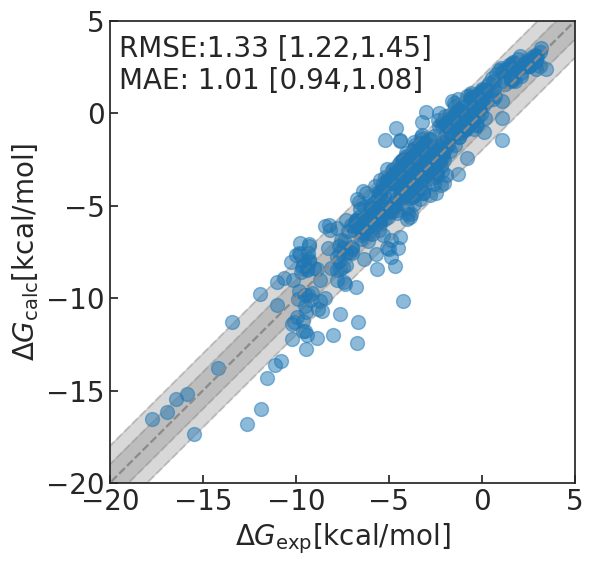

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(6, 6))

def plotting_grey_area(i, one_plot=False):
    # shaded grey area
    if one_plot:
        x = np.linspace(-30, 20, 5)
        y = x
        axs.plot(x, y, alpha=0.9, color="C7", linestyle="dashed")
        y2 = x + 1
        axs.plot(x, y2, alpha=0.3, color="C7", linestyle="dashed")
        y3 = x - 1
        axs.plot(x, y3, alpha=0.3, color="C7", linestyle="dashed")
        axs.fill_between(x, y2, y3, alpha=0.3, color="Grey")

        x = np.linspace(-30, 20, 5)
        y = x
        axs.plot(x, y, alpha=0.9, color="C7", linestyle="dashed")
        y2 = x + 2
        axs.plot(x, y2, alpha=0.3, color="C7", linestyle="dashed")
        y3 = x - 2
        axs.plot(x, y3, alpha=0.3, color="C7", linestyle="dashed")
        axs.fill_between(x, y2, y3, alpha=0.3, color="Grey")

plotting_grey_area(0, one_plot=True)
axs.scatter(
    all_data["Exp [kcal/mol]"],
    all_data["MM-ASFE [kcal/mol]"],
    alpha=0.5,
    color=c1,
    label="MM",
)

rmse,mae,_,_,_ = calculate_statistics(all_data["Exp [kcal/mol]"],all_data["MM-ASFE [kcal/mol]"])

axs.text(
    0.02,
    0.97,
    f"RMSE:{rmse[0]} [{rmse[1]},{rmse[2]}]\nMAE: {mae[0]} [{mae[1]},{mae[2]}]",
    transform=axs.transAxes,
    fontsize=20,
    verticalalignment="top",
)

axs.set_ylabel(r"$\Delta G_{\mathrm{calc}} \mathrm{[kcal/mol]}$",fontsize=20)
axs.set_xlabel(r"$\Delta G_{\mathrm{exp}} \mathrm{[kcal/mol]}$",fontsize=20)

axs.set_ylim([-20,5])
axs.set_xlim([-20,5])

plt.savefig("ASFE_EXS.pdf",bbox_inches="tight")


Results for the **OpenFF** data for the lare dataset (**589 molecules**)

In [ ]:
print(f"###### Without Correction -- pure MM results ######")
zip(calculate_statistics(all_data["Exp [kcal/mol]"], all_data["MM-ASFE [kcal/mol]"], output=True))
print(f"###### Corrected results ######")
zip(calculate_statistics(all_data["Exp [kcal/mol]"], all_data["ML-ASFE [kcal/mol]"], output=True))

###### Without Correction -- pure MM results ######
rmse=(1.330067204177469, 1.2214590418755364, 1.4459428957418035)
kendall=(0.8073610822743054, 0.7874259434634436, 0.8269444668709757)
mae=(1.007088693571112, 0.9390537502959327, 1.0755837000915174)
pearson=(0.9484904173902535, 0.9390524336051084, 0.9570415032571994)
spearman=(0.9454640731217808, 0.9302457990489023, 0.9550860477134726)
###### Corrected results ######
rmse=(1.2976025349548554, 1.19455777905726, 1.4157842570362464)
kendall=(0.8172065263623257, 0.7983854809268451, 0.8333376719089162)
mae=(0.9826517870454891, 0.9147877036715227, 1.05165140756184)
pearson=(0.9561251631357194, 0.944455181919999, 0.9661489528622632)
spearman=(0.9515281686364163, 0.9391801727964916, 0.9607923013888411)


Results for the **OpenFF** data

In [ ]:
print(f"###### Without Correction -- pure MM results ######")
zip(calculate_statistics(data["Exp [kcal/mol]"], data["MM-ASFE [kcal/mol]"], output=True))
print(f"###### Corrected results ######")
zip(calculate_statistics(data["Exp [kcal/mol]"], data["ML-ASFE [kcal/mol]"], output=True))

###### Without Correction -- pure MM results ######
rmse=(2.1118593930832246, 1.9129946172137047, 2.304322167859386)
kendall=(0.7477657045273158, 0.703733876795697, 0.7928875461499685)
mae=(1.832903846153846, 1.6851350961538463, 1.9808366987179487)
pearson=(0.9009730599223598, 0.8745715238216191, 0.9232364083381442)
spearman=(0.9116292927150935, 0.8793655454853304, 0.9350631428911903)
###### Corrected results ######
rmse=(1.9213894645175338, 1.7256921064324173, 2.1279002067375554)
kendall=(0.7633746497945529, 0.7116198528639829, 0.8040878898751243)
mae=(1.612679487179487, 1.4519921474358974, 1.7732786858974363)
pearson=(0.9336337343230723, 0.9046156622666104, 0.9565993775725308)
spearman=(0.9225207028273911, 0.8922280460631445, 0.9440201624151721)


Results for the **CGenFF** data

In [ ]:
print(f"###### Without Corretion -- pure MM results ######")
zip(calculate_statistics(data["Exp [kcal/mol]"], data["dG (TF) lrc"], output=True))
print(f"###### Corrected results Jar ######")
zip(calculate_statistics(data["Exp [kcal/mol]"], data["Jar result"], output=True))

###### Without Corretion -- pure MM results ######
rmse=(3.102333179051882, 2.5866533582244693, 3.610325368375082)
kendall=(0.5999420510955144, 0.5098188666302956, 0.6857390497563236)
mae=(2.3300641025641027, 2.016897435897436, 2.6455448717948715)
pearson=(0.7710679463156318, 0.6982297125110289, 0.8315778086683855)
spearman=(0.7603576108070345, 0.6606427559057352, 0.8347696237619786)
###### Corrected results Jar ######
rmse=(2.947929847302236, 2.411240823828604, 3.523729420704191)
kendall=(0.5998427476021426, 0.508517608687771, 0.6772011424078367)
mae=(2.1355769230769233, 1.820639423076923, 2.46923076923077)
pearson=(0.8092223954994389, 0.7274158942916095, 0.870332310043837)
spearman=(0.7581624194090653, 0.6495462558007725, 0.837826313996582)


In [ ]:
print(
    f"Molecules for OpenFF where correction is greater than: {len(data.drop(data[np.abs(data['MM-ASFE [kcal/mol]']-data['ML-ASFE [kcal/mol]']) < 0.3 ].index))}"
)
print(
    f"Molecules for CGenFF where correction is greater than: {len(data.drop(data[np.abs(data['Jar correction']) < 0.3 ].index))}"
)

Molecules for OpenFF where correction is greater than: 60
Molecules for CGenFF where correction is greater than: 67


In [ ]:
data["EXS correction"] = np.abs(data["ML-ASFE [kcal/mol]"] - data["MM-ASFE [kcal/mol]"])

In [ ]:
results = {}
results_cgenff = {}
results_cgenff_crooks = {}
mae_results = {}
mae_results_cgenff = {}
mae_results_cgenff_crooks = {}
for i in range(0, 6, 1):
    i = i / 10
    reducedData = data.drop(data[np.abs(data["EXS correction"]) < i].index)
    reducedData = reducedData.drop(
        reducedData[np.abs(reducedData["Jar correction"]) < i].index
    )
    ###### Without Corretion -- pure MM results ######
    rmse0, mae0, _, _, _ = calculate_statistics(
        reducedData["Exp [kcal/mol]"], reducedData["MM-ASFE [kcal/mol]"]
    )
    Crmse0, Cmae0, _, _, _ = calculate_statistics(
        reducedData["Exp [kcal/mol]"], reducedData["dG (TF) lrc"]
    )
    ###### Corrected results ######
    rmse1, mae1, _, _, _ = calculate_statistics(
        reducedData["Exp [kcal/mol]"], reducedData["ML-ASFE [kcal/mol]"]
    )
    Crmse1, Cmae1, _, _, _ = calculate_statistics(
        reducedData["Exp [kcal/mol]"], reducedData["Jar result"]
    )
    CrooksRmse1, CrooksMae1, _, _, _ = calculate_statistics(
        reducedData["Exp [kcal/mol]"], reducedData["Crooks result"]
    )
    results[i] = rmse0 - rmse1, len(reducedData)
    results_cgenff[i] = Crmse0 - Crmse1, len(reducedData)
    results_cgenff_crooks[i] = Crmse0 - CrooksRmse1
    mae_results[i] = mae0 - mae1, len(reducedData)
    mae_results_cgenff[i] = Cmae0 - Cmae1, len(reducedData)
    mae_results_cgenff_crooks[i] = Cmae0 - CrooksMae1

TypeError: ignored

In [ ]:
fig, ax1 = plt.subplots(1, 2, figsize=(11, 4), sharex=True)
fig.subplots_adjust(wspace=0.3)
ax1[0].scatter(results.keys(), [item[0] for item in results.values()], label="OpenFF")
ax1[0].scatter(
    results_cgenff.keys(),
    [item[0] for item in results_cgenff.values()],
    marker="v",
    label="CGenFF- Jar",
)
ax1[0].scatter(
    results_cgenff_crooks.keys(),
    results_cgenff_crooks.values(),
    marker="v",
    label="CGenFF- Crooks",
)
ax1[0].set_ylabel("Decrease in kcal/mol")
ax1[0].set_title("RMSE")
ax1[0].set_xlabel("Minimal absolute correction (kcal/mol)")
ax2 = ax1[0].twinx()
ax2.scatter(
    results.keys(),
    [item[1] for item in results.values()],
    marker="x",
    color="black",
    label="# of molecules",
    alpha=0.5,
)
ax2.set_ylabel("# of molceules")
ax1[0].legend(frameon=True, loc="upper center")

ax1[1].scatter(
    mae_results.keys(), [item[0] for item in mae_results.values()], label="OpenFF"
)
ax1[1].scatter(
    mae_results_cgenff.keys(),
    [item[0] for item in mae_results_cgenff.values()],
    marker="v",
    label="CGenFF- Jar",
)
ax1[1].scatter(
    mae_results_cgenff_crooks.keys(),
    mae_results_cgenff_crooks.values(),
    marker="v",
    label="CGenFF- Crooks",
)
ax1[1].set_ylabel("Decrease in kcal/mol")
ax1[1].set_xlabel("Minimal absolute correction")
ax1[1].set_title("MAE")

In [ ]:
def GenerateConformers(mol, numConfs):
    # Add Hydrogens to the skeleton
    molecule = Chem.AddHs(mol)

    conformerIntegers = []

    # Embed and optimize the conformers
    conformers = rdDistGeom.EmbedMultipleConfs(
        molecule, numConfs, pruneRmsThresh=0.5, numThreads=8
    )
    optimized_and_energies = rdForceFieldHelpers.MMFFOptimizeMoleculeConfs(
        molecule, maxIters=600, numThreads=8, nonBondedThresh=100.0
    )

    EnergyDictionaryWithIDAsKey = {}
    FinalConformersToUse = {}

    # Only keep the conformers which were successfully fully optimized
    for conformer in conformers:
        optimized, energy = optimized_and_energies[conformer]
        if optimized == 0:
            EnergyDictionaryWithIDAsKey[conformer] = energy
            conformerIntegers.append(conformer)

    # Keep the lowest energy conformer
    lowestEnergy = min(EnergyDictionaryWithIDAsKey.values())

    for k, v in EnergyDictionaryWithIDAsKey.items():
        if v == lowestEnergy:
            lowestEnergyConformerID = k

    FinalConformersToUse[lowestEnergyConformerID] = lowestEnergy

    # Remove Hydrogens to speed up substructure matching
    molecule = AllChem.RemoveHs(molecule)

    # Find all substructure matches of the molecule with itself, to account for symmetry
    matches = molecule.GetSubstructMatches(molecule, uniquify=False)
    maps = [list(enumerate(match)) for match in matches]

    # Loop over conformers other than the lowest energy one
    for conformerID in EnergyDictionaryWithIDAsKey.keys():
        okayToAdd = True

        # Loop over reference conformers already added to list
        for finalConformerID in FinalConformersToUse.keys():
            # Calculate the best RMS of this conformer with the reference conformer in the list
            RMS = AllChem.GetBestRMS(
                molecule, molecule, finalConformerID, conformerID, maps
            )

            # Do not add if a match is found with a reference conformer
            if RMS < 1.0:
                okayToAdd = False
                break

        # Add the conformer if the RMS is greater than 1.0 for every reference conformer
        if okayToAdd:
            FinalConformersToUse[conformerID] = EnergyDictionaryWithIDAsKey[conformerID]

    # Sort the conformers by energy
    sortedDictionary = OrderedDict(
        sorted(FinalConformersToUse.items(), key=lambda t: t[1])
    )

    energies = [val for val in sortedDictionary.values()]

    return energies


def CalcConf20(energyList):
    energyDescriptor = 0

    relativeEnergies = np.array(energyList) - energyList[0]

    # Only look at the energies of conformers other than the global minimum
    for energy in relativeEnergies[1:]:
        # Optimize lower and upper energy limits for conformer energy
        if 0 <= energy < 20:
            energyDescriptor += 1

    return energyDescriptor


def CalcConf20(molecule):
    energyList = GenerateConformers(molecule, 100)
    energyDescriptor = 0

    relativeEnergies = np.array(energyList) - energyList[0]

    # Only look at the energies of conformers other than the global minimum
    for energy in relativeEnergies[1:]:
        # Optimize lower and upper energy limits for conformer energy
        if 0 <= energy < 20:
            energyDescriptor += 1

    return energyDescriptor

In [ ]:
data["MM-ML"] = np.abs(data["MM-ASFE [kcal/mol]"] - data["ML-ASFE [kcal/mol]"])

In [ ]:
data.loc[:, "numRotBonds"] = np.nan
data.loc[:, "hallkier"] = np.nan
data.loc[:, "conf20"] = np.nan

numRotBonds = {}
for index, row in data.iterrows():
    try:
        smi = row[" SMILES"].strip()
        correction = row["MM-ML"]
        mol = Chem.MolFromSmiles(smi)
        # display(mol)
        rotBonds = rdMolDescriptors.CalcNumRotatableBonds(mol)
        hallkier = GraphDescriptors.HallKierAlpha(mol)
        conf20 = CalcConf20(mol)
        data.loc[index, "numRotBonds"] = rotBonds
        data.loc[index, "hallkier"] = hallkier
        data.loc[index, "conf20"] = conf20
        # print(rotBonds)
        try:
            numRotBonds[rotBonds].append(correction)

        except KeyError:
            numRotBonds[rotBonds] = []
            numRotBonds[rotBonds].append(correction)
    except AttributeError:
        pass

In [ ]:
results = {}
results_cgenff = {}
results_cgenff_crooks = {}
mae_results = {}
mae_results_cgenff = {}
mae_results_cgenff_crooks = {}
for i in range(0, 8):
    reducedData = data.drop(data[data["numRotBonds"] < i].index)
    reducedData = reducedData.drop(
        reducedData[np.abs(reducedData["Jar correction"]) < 0.1].index
    )
    reducedData = reducedData.drop(
        reducedData[np.abs(reducedData["EXS correction"]) < 0.1].index
    )
    ###### Without Corretion -- pure MM results ######
    rmse0, mae0, _, _, _ = calculate_statistics(
        reducedData["Exp [kcal/mol]"], reducedData["MM-ASFE [kcal/mol]"]
    )
    Crmse0, Cmae0, _, _, _ = calculate_statistics(
        reducedData["Exp [kcal/mol]"], reducedData["dG (TF) lrc"]
    )
    ###### Corrected results ######
    rmse1, mae1, _, _, _ = calculate_statistics(
        reducedData["Exp [kcal/mol]"], reducedData["ML-ASFE [kcal/mol]"]
    )
    Crmse1, Cmae1, _, _, _ = calculate_statistics(
        reducedData["Exp [kcal/mol]"], reducedData["Jar result"]
    )
    CrooksRmse1, CrooksMae1, _, _, _ = calculate_statistics(
        reducedData["Exp [kcal/mol]"], reducedData["Crooks result"]
    )
    mae_results[i] = mae0 - mae1, len(reducedData)
    mae_results_cgenff[i] = Cmae0 - Cmae1, len(reducedData)
    mae_results_cgenff_crooks[i] = Cmae0 - CrooksMae1
    results[i] = rmse0 - rmse1, len(reducedData)
    results_cgenff[i] = rmse0 - Crmse1, len(reducedData)
    results_cgenff_crooks[i] = Crmse0 - CrooksRmse1

In [ ]:
fig, ax1 = plt.subplots(1, 2, figsize=(11, 4), sharex=True)
fig.subplots_adjust(wspace=0.4)
ax1[0].scatter(results.keys(), [item[0] for item in results.values()], label="OpenFF")
ax1[0].scatter(
    results_cgenff.keys(),
    [item[0] for item in results_cgenff.values()],
    marker="v",
    label="CGenFF- Jar",
)
ax1[0].scatter(
    results_cgenff_crooks.keys(),
    results_cgenff_crooks.values(),
    marker="v",
    label="CGenFF- Crooks",
)
ax1[0].set_ylabel("Decrease in kcal/mol")
ax1[0].set_title("RMSE")
ax1[0].set_xlabel("Minimum number of rotatable bonds")
ax2 = ax1[0].twinx()
ax2.scatter(
    results.keys(),
    [item[1] for item in results.values()],
    marker="x",
    color="black",
    label="# of molecules",
    alpha=0.5,
)
ax2.set_ylabel("# of molceules")
ax1[0].axhline(0, color="black", linestyle="dashed")
ax1[0].legend(frameon=False, loc="lower left")

ax1[1].scatter(
    mae_results.keys(), [item[0] for item in mae_results.values()], label="OpenFF"
)
ax1[1].scatter(
    mae_results_cgenff.keys(),
    [item[0] for item in mae_results_cgenff.values()],
    marker="v",
    label="CGenFF- Jar",
)
ax1[1].scatter(
    mae_results_cgenff_crooks.keys(),
    mae_results_cgenff_crooks.values(),
    marker="v",
    label="CGenFF- Crooks",
)
ax1[1].set_ylabel("Decrease in kcal/mol")
ax1[1].axhline(0, color="black", linestyle="dashed")
ax1[1].set_xlabel("Minimum number of rotatable bonds")
ax1[1].set_title("MAE")

In [ ]:
mae_results_cgenff

In [ ]:
reduced_data = data.drop(data[data["numRotBonds"] < 5].index)
reducedData = reducedData.drop(
    reducedData[np.abs(reducedData["Jar correction"]) < 0.1].index
)
reducedData = reducedData.drop(
    reducedData[np.abs(reducedData["EXS correction"]) < 0.1].index
)
rmse0, mae0, _, _, _ = calculate_statistics(
    reducedData["Exp [kcal/mol]"], reducedData["MM-ASFE [kcal/mol]"]
)
Crmse0, Cmae0, _, _, _ = calculate_statistics(
    reducedData["Exp [kcal/mol]"], reducedData["dG (TF) lrc"]
)
###### Corrected results ######
rmse1, mae1, _, _, _ = calculate_statistics(
    reducedData["Exp [kcal/mol]"], reducedData["ML-ASFE [kcal/mol]"]
)
Crmse1, Cmae1, _, _, _ = calculate_statistics(
    reducedData["Exp [kcal/mol]"], reducedData["Jar result"]
)
CrooksRmse1, CrooksMae1, _, _, _ = calculate_statistics(
    reducedData["Exp [kcal/mol]"], reducedData["Crooks result"]
)

In [ ]:
Cmae0 - Cmae1

In [ ]:
results = {}
results_cgenff = {}
results_cgenff_crooks = {}

for i in range(0, 6, 1):
    i = i / 10
    reducedData = data.drop(data[np.abs(data["EXS correction"]) < i].index)
    # for i in range(0,8):
    #   reducedData = data.drop(data[data['numRotBonds'] < i ].index)

    rightDirection = 0
    wrongDirection = 0

    for index, row in reducedData.iterrows():
        deviation_mm = np.abs(row["MM-ASFE [kcal/mol]"] - row["Exp [kcal/mol]"])
        deviation_corrected = np.abs(row["ML-ASFE [kcal/mol]"] - row["Exp [kcal/mol]"])
        if deviation_mm > deviation_corrected:
            rightDirection += 1
        else:
            wrongDirection += 1

        results[i] = round(rightDirection / (rightDirection + wrongDirection) * 100, 2)

        rightDirection = 0
        wrongDirection = 0

        for index, row in reducedData.iterrows():
            deviation_mm = np.abs(row["dG (TF) lrc"] - row["Exp [kcal/mol]"])
            deviation_corrected = np.abs(row["Jar result"] - row["Exp [kcal/mol]"])
            if deviation_mm > deviation_corrected:
                rightDirection += 1
            else:
                wrongDirection += 1

            results_cgenff[i] = round(
                rightDirection / (rightDirection + wrongDirection) * 100, 2
            )

        rightDirection = 0
        wrongDirection = 0

        for index, row in reducedData.iterrows():
            deviation_mm = np.abs(row["dG (TF) lrc"] - row["Exp [kcal/mol]"])
            deviation_corrected = np.abs(row["Crooks result"] - row["Exp [kcal/mol]"])
            if deviation_mm > deviation_corrected:
                rightDirection += 1
            else:
                wrongDirection += 1

            results_cgenff_crooks[i] = round(
                rightDirection / (rightDirection + wrongDirection) * 100, 2
            )

In [ ]:
results

In [ ]:
fig, ax1 = plt.subplots()
ax1.scatter(results.keys(), results.values(), label="OpenFF")
ax1.scatter(
    results_cgenff.keys(), results_cgenff.values(), marker="v", label="CGenFF - Jar"
)
ax1.scatter(
    results_cgenff_crooks.keys(),
    results_cgenff_crooks.values(),
    marker="^",
    label="CGenFF - Crooks",
    alpha=0.5,
)
ax1.set_ylabel("prediction in correct direction (%)")
ax1.legend()

In [ ]:
!pip install molcomplib

In [ ]:
# from molcomplib import MolCompass
# compass = MolCompass()
# list_of_compounds = [smi.strip() for smi in data[" SMILES"]]
# res = np.vstack([compass(compound) for compound in list_of_compounds])

In [ ]:
from molcomplib import MolCompass
import plotly.express as px

In [ ]:
data = pd.read_csv("sample_data/combinedDataset.csv")
data["Crooks correction"] = np.abs(data["Crooks correction"])
data = data.sort_values(by="Crooks correction")
data = data[0:130]

molcomp = MolCompass()
df = pd.DataFrame({"smiles": [smi.strip() for smi in data[" SMILES"]]})
res = molcomp.process(df)

fig = px.scatter(
    res,
    x="x",
    y="y",
    color=np.abs(data["Crooks correction"]),
    hover_name=data[" SMILES"],
    color_continuous_scale=px.colors.sequential.Bluered,
)
fig.update_layout(width=800, height=600)
fig.show()

In [ ]:
data = pd.read_csv("sample_data/combinedDataset.csv")
data.loc[:, "direction"] = np.nan

for index, row in data.iterrows():
    deviation_mm = np.abs(row["dG (TF) lrc"] - row["Exp [kcal/mol]"])
    deviation_corrected = np.abs(row["Crooks result"] - row["Exp [kcal/mol]"])
    if deviation_mm > deviation_corrected:
        data.loc[index, "direction"] = 1  # correct direction
    else:
        data.loc[index, "direction"] = 0  # wrong direction

In [ ]:
molcomp = MolCompass()
df = pd.DataFrame({"smiles": [smi.strip() for smi in data[" SMILES"]]})
res = molcomp.process(df)

In [ ]:
fig = px.scatter(res, x="x", y="y", hover_name=data[" SMILES"], color=data["direction"])
fig.update_layout(width=800, height=600)
fig.show()

Wrong direction: 35.48% of 155 compounds


[]

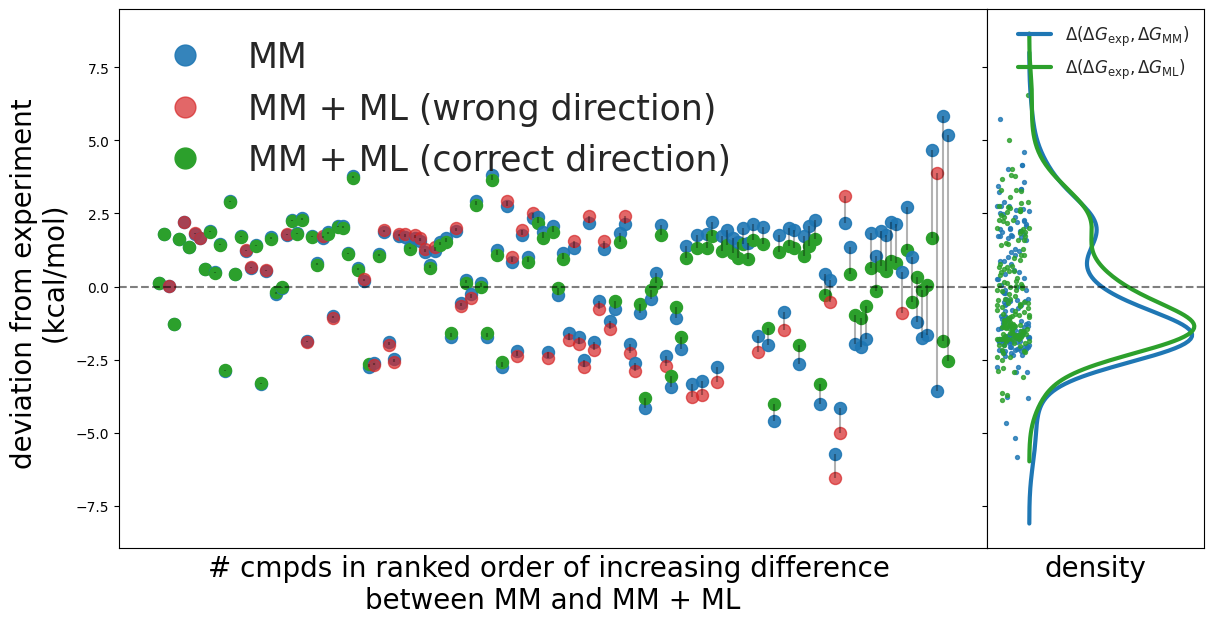

In [ ]:
data = pd.read_csv("sample_data/combinedDataset.csv")
all_data = pd.read_csv("sample_data/freesolvEXSdata.csv", skiprows=1)
data["MM-ML"] = np.abs(data["MM-ASFE [kcal/mol]"] - data["ML-ASFE [kcal/mol]"])


fig, ax = plt.subplots(
    1, 2, figsize=(14, 7), sharey=True, gridspec_kw={"width_ratios": [4, 1]}
)
fig.subplots_adjust(hspace=0, wspace=0)

sns.set_theme(
    style="white",
    rc={
        "font.size": 15,
        "legend.fontsize": 25,
        "lines.markersize": 10,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "ytick.left": True,
    },
)

data = data.sort_values(by="MM-ML", ascending=True)

wrong = []
correct = []
for index, row in data.iterrows():
    if not np.isnan(data["Exp [kcal/mol]"][index]):
        noCorrection = np.abs(
            data["Exp [kcal/mol]"][index] - data["MM-ASFE [kcal/mol]"][index]
        )
        corrected = np.abs(
            data["Exp [kcal/mol]"][index] - data["ML-ASFE [kcal/mol]"][index]
        )
        if np.abs(data["MM-ML"][index]) > 0.00001:
            ax[0].scatter(
                data["Mol_ID"][index],
                (
                    (data["Exp [kcal/mol]"][index] * -1)
                    + data["MM-ASFE [kcal/mol]"][index]
                ),
                s=75,
                # fmt="o",
                # capsize=3,
                # yerr=data["std (TF)"][index],
                color=c1,
                alpha=0.9,
            )

            if noCorrection >= corrected:
                ax[0].scatter(
                    data["Mol_ID"][index],
                    (
                        (data["Exp [kcal/mol]"][index] * -1)
                        + data["ML-ASFE [kcal/mol]"][index]
                    ),
                    s=75,
                    color=c3,
                )
                correct.append(1)
            else:
                ax[0].scatter(
                    data["Mol_ID"][index],
                    (
                        (data["Exp [kcal/mol]"][index] * -1)
                        + data["ML-ASFE [kcal/mol]"][index]
                    ),
                    s=75,
                    color=c4,
                    alpha=0.7,
                )
                wrong.append(1)

            ax[0].vlines(
                x=data["Mol_ID"][index],
                ymin=(
                    (data["Exp [kcal/mol]"][index] * -1)
                    + data["MM-ASFE [kcal/mol]"][index]
                ),
                ymax=(
                    (data["Exp [kcal/mol]"][index] * -1)
                    + data["ML-ASFE [kcal/mol]"][index]
                ),
                colors="black",
                alpha=0.3,
            )


blue_patch = matplotlib.lines.Line2D(
    [0], [0], marker="o", color=c1, label="MM", ls="None", alpha=0.9, ms=15
)
red_patch = matplotlib.lines.Line2D(
    [0],
    [0],
    marker="o",
    color=c4,
    label="MM + ML (wrong direction)",
    alpha=0.7,
    ls="None",
    ms=15,
)
green_patch = matplotlib.lines.Line2D(
    [0],
    [0],
    marker="o",
    color=c3,
    label="MM + ML (correct direction)",
    ls="None",
    ms=15,
)

ax[0].legend(
    handles=[blue_patch, red_patch, green_patch], frameon=False, loc="upper left"
)


ax[0].axhline(y=0, linestyle="--", color="black", alpha=0.5)
# plt.axhline(y=-2, linestyle="--", color="black")
# plt.axhline(y=2, linestyle="--", color="black")
ax[0].set_xlabel(
    "# cmpds in ranked order of increasing difference \nbetween MM and MM + ML",
    fontsize=20,
)
ax[0].set_ylabel("deviation from experiment \n (kcal/mol)", fontsize=20)
ax[0].set_xticks([])

print(
    f"Wrong direction: {round(len(wrong)/len(correct+wrong)*100,2)}% of {len(correct+wrong)} compounds"
)

sns.kdeplot(
    y=data["Exp [kcal/mol]"] - data["MM-ASFE [kcal/mol]"],
    color=c1,
    linewidth=3,
    label=r"$\Delta(\Delta G_{\mathrm{exp}},\Delta G_{\mathrm{MM}})$",
    ax=ax[1],
)
sns.kdeplot(
    y=data["Exp [kcal/mol]"] - data["ML-ASFE [kcal/mol]"],
    color=c3,
    linewidth=3,
    label=r"$\Delta(\Delta G_{\mathrm{exp}},\Delta G_{\mathrm{ML}})$",
    ax=ax[1],
)
ax[1].scatter(
    np.random.uniform(low=-0.05, high=0.0, size=len(data["ML-ASFE [kcal/mol]"])),
    data["Exp [kcal/mol]"] - data["MM-ASFE [kcal/mol]"],
    s=8,
    color=c1,
    alpha=0.8,
)
ax[1].scatter(
    np.random.uniform(low=-0.05, high=0, size=len(data["ML-ASFE [kcal/mol]"])),
    data["Exp [kcal/mol]"] - data["ML-ASFE [kcal/mol]"],
    s=8,
    color=c3,
    alpha=0.8,
)
ax[1].axhline(0, color="black", linestyle="dashed", alpha=0.5)
ax[1].set_xlabel("density", fontsize=20)
ax[1].legend(
    fontsize=12, frameon=False, loc="upper right"
)  # ,bbox_to_anchor=(1.8, 1.0, 0.0, 0.0))
ax[1].set_xticks([])
# ax[1].spines['right'].set_visible(False)
# ax[1].spines['top'].set_visible(False)

# plt.savefig("overview.png", bbox_inches="tight")

Text(0.5, 0, 'density')

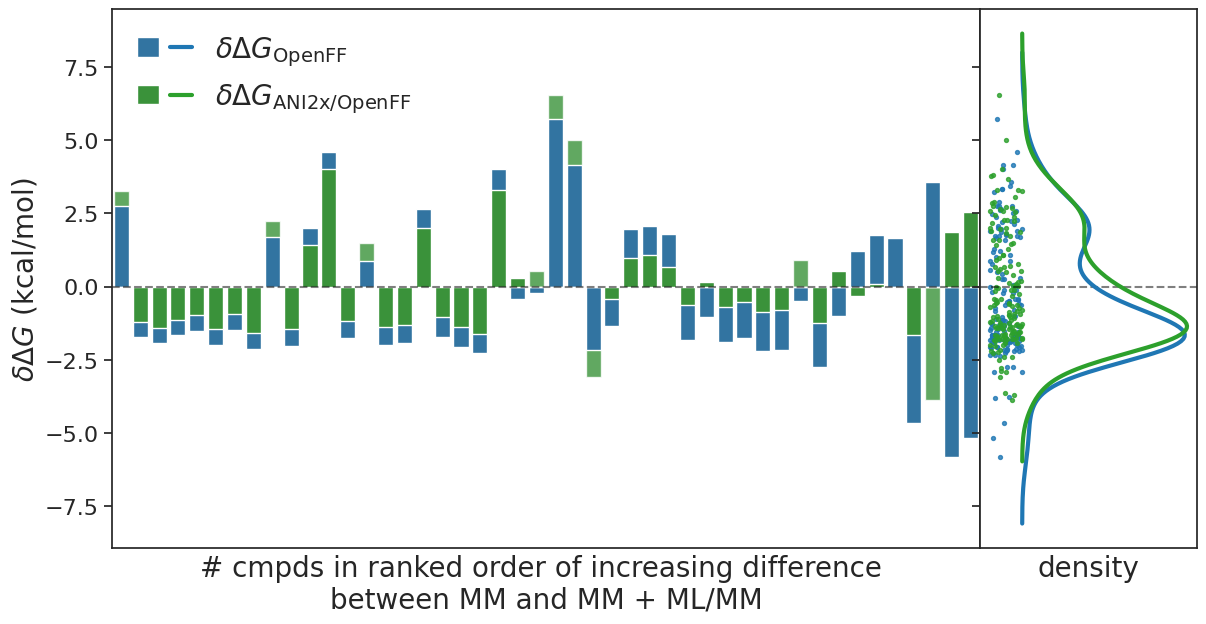

In [ ]:
data["EXS correction"] = np.abs(data["ML-ASFE [kcal/mol]"] - data["MM-ASFE [kcal/mol]"])
reduced_data = data.drop(data[np.abs(data["EXS correction"]) < 0.5].index)
reduced_data = reduced_data.sort_values(by="MM-ML", ascending=True)


reduced_data.loc[:, "correctDirection"] = np.nan
reduced_data.loc[:, "wrongDirection"] = np.nan

for index, row in reduced_data.iterrows():
    if not np.isnan(reduced_data["Exp [kcal/mol]"][index]):
        noCorrection = np.abs(
            reduced_data["Exp [kcal/mol]"][index]
            - reduced_data["MM-ASFE [kcal/mol]"][index]
        )
        corrected = np.abs(
            reduced_data["Exp [kcal/mol]"][index]
            - reduced_data["ML-ASFE [kcal/mol]"][index]
        )
        if np.abs(reduced_data["MM-ML"][index]) > 0.00001:
            if noCorrection >= corrected:  # correct Direction
                # data.loc[index, "correctDirection"] = np.abs(data["ML-ASFE [kcal/mol]"][index]-data["Exp [kcal/mol]"][index])
                reduced_data.loc[index, "correctDirection"] = (
                    reduced_data["Exp [kcal/mol]"][index]
                    - reduced_data["ML-ASFE [kcal/mol]"][index]
                )
                reduced_data.loc[index, "wrongDirection"] = 0
            else:
                reduced_data.loc[index, "correctDirection"] = 0
                # data.loc[index, "wrongDirection"] = np.abs(data["ML-ASFE [kcal/mol]"][index]-data["Exp [kcal/mol]"][index])
                reduced_data.loc[index, "wrongDirection"] = (
                    reduced_data["Exp [kcal/mol]"][index]
                    - reduced_data["ML-ASFE [kcal/mol]"][index]
                )

fig, ax = plt.subplots(
    1, 2, figsize=(14, 7), sharey=True, gridspec_kw={"width_ratios": [4, 1]}
)
fig.subplots_adjust(hspace=0, wspace=0.0)

sns.set_theme(
    style="white",
    rc={
        "font.size": 20,
        "legend.fontsize": 25,
        "lines.markersize": 10,
        "xtick.labelsize": 12,
        "ytick.labelsize": 16,
        "ytick.left": True,
    },
)

# sns.barplot(x=data["Mol_ID"],y=np.abs(data["MM-ASFE [kcal/mol]"]-data["Exp [kcal/mol]"]),data=data,label="MM",ec="white", ax=ax[0],color=c1)
sns.barplot(
    x=reduced_data["Mol_ID"],
    y=(reduced_data["Exp [kcal/mol]"] - reduced_data["MM-ASFE [kcal/mol]"]),
    data=reduced_data,
    label="MM",
    ec="white",
    ax=ax[0],
    color=c1,
)
sns.barplot(
    x="Mol_ID",
    y=reduced_data["correctDirection"],
    data=reduced_data,
    ax=ax[0],
    color=c3,
    ec="white",
    label="ML correct",
)
sns.barplot(
    x="Mol_ID",
    y=reduced_data["wrongDirection"],
    data=reduced_data,
    ax=ax[0],
    label="ML wrong",
    color=c3,
    ec="white",
    zorder=0,
    alpha=0.8,
)

ax[0].set_ylabel(r"$\delta \Delta G$ (kcal/mol)", fontsize=20)

ax[0].set_xlabel(
    "# cmpds in ranked order of increasing difference \nbetween MM and MM + ML/MM",
    fontsize=20,
)
ax[0].set_xticks([])
ax[0].axhline(0, color="black", linestyle="dashed", alpha=0.5)
ax[1].axhline(0, color="black", linestyle="dashed", alpha=0.5)

sns.kdeplot(
    y=(data["Exp [kcal/mol]"] - data["MM-ASFE [kcal/mol]"]),
    color=c1,
    linewidth=3,
    label=r"$\Delta(\Delta G_{\mathrm{exp}},\Delta G_{\mathrm{MM}})$",
    ax=ax[1],
)
sns.kdeplot(
    y=(data["Exp [kcal/mol]"] - data["ML-ASFE [kcal/mol]"]),
    color=c3,
    linewidth=3,
    label=r"$\Delta(\Delta G_{\mathrm{exp}},\Delta G_{\mathrm{ML}})$",
    ax=ax[1],
)
ax[1].scatter(
    np.random.uniform(low=-0.05, high=0.0, size=len(data["ML-ASFE [kcal/mol]"])),
    (data["Exp [kcal/mol]"] - data["MM-ASFE [kcal/mol]"]),
    label="ML",
    s=8,
    color=c1,
    alpha=0.8,
)
ax[1].scatter(
    np.random.uniform(low=-0.05, high=0, size=len(data["ML-ASFE [kcal/mol]"])),
    (data["Exp [kcal/mol]"] - data["ML-ASFE [kcal/mol]"]),
    s=8,
    color=c3,
    alpha=0.8,
)

ax[0].set_xticklabels(
    ax[0].get_xticklabels(), rotation=90
)  # Adjust the rotation angle as needed
ax[1].set_xticks([])

lines_labels = [axs.get_legend_handles_labels() for axs in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax[0].legend(
    [(lines[0], lines[3]), (lines[1], lines[4])],
    # [r"$\Delta (\Delta \mathrm{G}_{\mathrm{MM}}, \Delta \mathrm{G}_{\mathrm{exp}})$",r"$\Delta (\Delta \mathrm{G}_{\mathrm{MM}},\Delta \mathrm{G}_{\mathrm{exp}} [<|>] \Delta (\Delta \mathrm{G}_{\mathrm{MM}} + \Delta \mathrm{G}^{{corr}}_{\mathrm{ML}}  , \Delta \mathrm{G}_{\mathrm{exp}})$"], #,r"$\Delta \mathrm{G}_{\mathrm{MM}} + \Delta \mathrm{G}^{{corr}}_{\mathrm{ML}} > \Delta(\Delta \mathrm{G}_{\mathrm{MM}}, \Delta \mathrm{G}_{\mathrm{exp}})$"],
    [
        r"$\delta\Delta G_{\mathrm{OpenFF}}$",
        r"$\delta\Delta G_{\mathrm{ANI2x/OpenFF}}$",
    ],
    loc="upper left",
    ncol=1,
    frameon=False,
    # bbox_to_anchor=(0.5, -0.1),
    fontsize=20,
    handler_map={tuple: HandlerTuple(ndivide=None)},
)

# ax[0].set_ylim([-7,7])

ax[1].set_xlabel("density", fontsize=20)

# plt.savefig("overview.pdf", bbox_inches="tight")